
--- Offline Model for Horizon 1 ---
Training samples: 6995, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 1 RMSE: 317.972

--- Offline Model for Horizon 2 ---
Training samples: 6994, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 2 RMSE: 605.328

--- Offline Model for Horizon 3 ---
Training samples: 6993, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 3 RMSE: 675.606

--- Offline Model for Horizon 4 ---
Training samples: 6992, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 4 RMSE: 801.161

--- Offline Model for Horizon 5 ---
Training samples: 6991, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 5 RMSE: 742.699

--- Online Model for Horizon 1 ---
Online model pre-training samples: 6995, Test samples: 1023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Online Horizon 1 RMSE: 462.876

--- Online Model for Horizon 2 ---
Online model pre-training samples: 6994, Test samples: 1023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Online Horizon 2 RMSE: 1276.915

--- Online Model for Horizon 3 ---
Online model pre-training samples: 6993, Test samples: 1023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Online Horizon 3 RMSE: 1116.372

--- Online Model for Horizon 4 ---
Online model pre-training samples: 6992, Test samples: 1023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Online Horizon 4 RMSE: 1160.920

--- Online Model for Horizon 5 ---
Online model pre-training samples: 6991, Test samples: 1023


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Online Horizon 5 RMSE: 1426.786


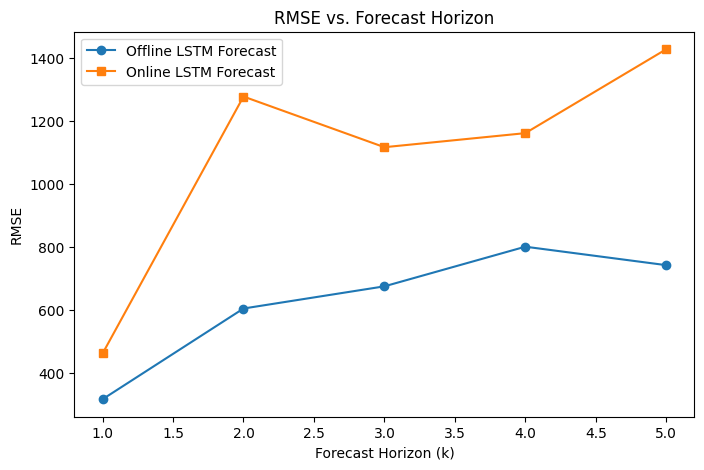

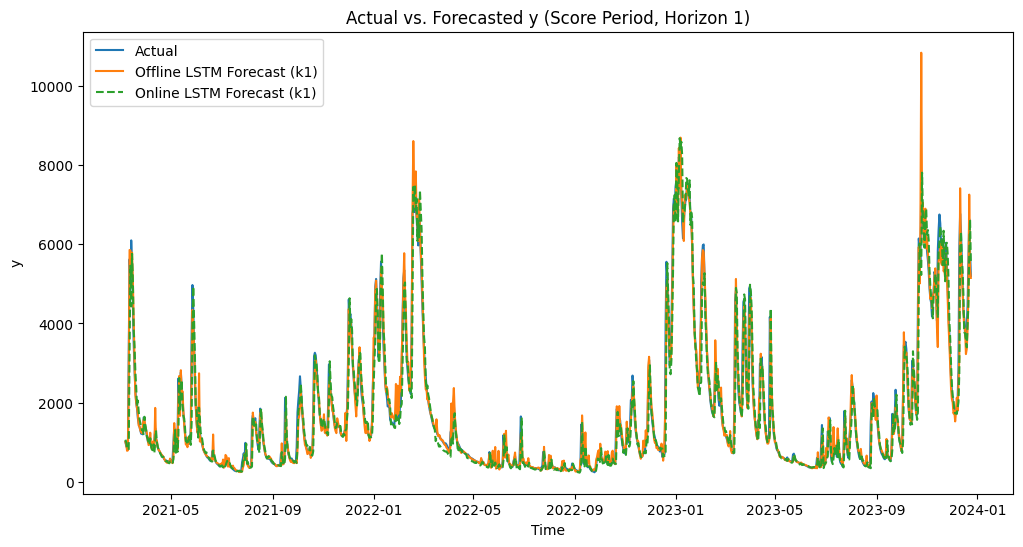

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

######################################
# Data Loading and Preprocessing
######################################

def low_pass(series, a1):
    """Exponential (low-pass) filter."""
    return series.ewm(alpha=1-a1, adjust=False).mean()

# Load the dataset (adjust the path as needed)
data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)

# Convert 'time' to datetime, set index and assign target 'y'
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()

# Data cleaning
temp_mask = D_time_indexed['temp_mean_daily'] > 35
D_time_indexed.loc[temp_mask, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = D_time_indexed['precip_total_daily'] > 100
D_time_indexed.loc[precip_mask, 'precip_total_daily'] = 0

# Create forecast features for the target day.
D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = low_pass(D_time_indexed['precip_total_daily'], a1=0.9)
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

# Define the score period: last 1023 days of data used only for evaluation
score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]  # All samples with target dates >= score_start go into the test set

######################################
# Parameters and Dataset Creation Functions
######################################
window_size = 10   # choose between 5 and 15
horizons = [1, 2, 3, 4, 5]  # forecast horizons

def create_offline_dataset_horizon(df, window_size, k, a1=0.9):
    """
    Creates samples for a given forecast horizon k.
    Each sample consists of:
      - Historical input: past window_size days of [y, temp_mean_daily, precip_total_daily]
      - Forecast input: target day's features [temp_forecast, precip_forecast, Year_sin, Year_cos]
            (target day is shifted by (k-1))
      - Label: target day's 'y'
    Also returns an array of target dates.
    """
    X_hist_list = []
    X_forecast_list = []
    y_list = []
    indices = []  # target dates
    for i in range(window_size, len(df) - (k-1)):
        target_date = df.index[i + (k-1)]
        hist = df.iloc[i-window_size:i][['y', 'temp_mean_daily', 'precip_total_daily']].values.astype(np.float32)
        # Forecast features from the target day:
        temp_fc = df.iloc[i + (k-1)]['temp_forecast']
        precip_fc = df.iloc[i + (k-1)]['precip_forecast']
        # Recompute seasonal features from target_date:
        year_sin = np.sin(2 * np.pi * target_date.dayofyear / 365)
        year_cos = np.cos(2 * np.pi * target_date.dayofyear / 365)
        fcst = np.array([temp_fc, precip_fc, year_sin, year_cos], dtype=np.float32)
        label = float(df.iloc[i+(k-1)]['y'])
        
        X_hist_list.append(hist)
        X_forecast_list.append(fcst)
        y_list.append(label)
        indices.append(target_date)
        
    return (np.array(X_hist_list, dtype=np.float32),
            np.array(X_forecast_list, dtype=np.float32),
            np.array(y_list, dtype=np.float32),
            np.array(indices))

######################################
# Model Architectures
######################################


# {'lstm_units': 64, 'dense_units': 64, 'fcst_dense_units': 32, 'combined_units': 64, 'lr': 0.001}
def build_offline_model(window_size):
    """
    Builds the offline LSTM model with two inputs:
      - A sequence input with shape (window_size, 3)
      - A forecast input with shape (4,)
    """
    hist_input = Input(shape=(window_size, 3), name='hist_input')
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(4,), name='fcst_input')
    y_branch = Dense(32, activation='relu')(fcst_input)
    y_branch = Dense(32, activation='relu')(y_branch)
    combined = Concatenate()([x, y_branch])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_online_model(window_size):
    """
    Builds a simple LSTM model for online forecasting using only historical inputs.
    Input shape: (window_size, 3)
    """
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 3)))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

######################################
# Offline Model: Training & Evaluation
######################################

offline_rmse = {}        # RMSE values for each horizon
offline_forecasts = {}   # (dates, actual, predicted) for plotting

for k in horizons:
    print(f"\n--- Offline Model for Horizon {k} ---")
    X_hist_all, X_fcst_all, y_all, indices_all = create_offline_dataset_horizon(D_time_indexed, window_size, k, a1=0.9)
    # Split based on date: training samples are those with target date < score_start;
    # test samples are those with target date >= score_start.
    train_mask = indices_all < score_start
    test_mask = indices_all >= score_start
    
    X_hist_train = X_hist_all[train_mask]
    X_fcst_train = X_fcst_all[train_mask]
    y_train = y_all[train_mask]
    
    X_hist_test = X_hist_all[test_mask]
    X_fcst_test = X_fcst_all[test_mask]
    y_test = y_all[test_mask]
    indices_test = indices_all[test_mask]
    
    print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")
    
    # If there are no test samples for this horizon, skip evaluation.
    if len(y_test) == 0:
        print(f"Horizon {k}: No test samples in score period; skipping evaluation.")
        offline_rmse[f'k{k}'] = np.nan
        offline_forecasts[f'k{k}'] = (np.array([]), np.array([]), np.array([]))
        continue
    
    offline_model = build_offline_model(window_size)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'offline_model_h{k}.keras', save_best_only=True)
    ]
    
    history = offline_model.fit(
        [X_hist_train, X_fcst_train], y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    y_pred = offline_model.predict([X_hist_test, X_fcst_test]).flatten()
    rmse = np.sqrt(np.nanmean((y_pred - y_test) ** 2))
    offline_rmse[f'k{k}'] = rmse
    offline_forecasts[f'k{k}'] = (indices_test, y_test, y_pred)
    print(f"Offline Horizon {k} RMSE: {rmse:.3f}")

######################################
# Online Model: Pre-training & Sequential Updating on Test Set
######################################

online_rmse = {}
online_forecasts = {}

for k in horizons:
    print(f"\n--- Online Model for Horizon {k} ---")
    X_hist_all, X_fcst_all, y_all, indices_all = create_offline_dataset_horizon(D_time_indexed, window_size, k, a1=0.9)
    # Use only samples with target date < score_start for pre-training.
    train_mask = indices_all < score_start
    test_mask = indices_all >= score_start
    
    X_hist_train = X_hist_all[train_mask]
    y_train = y_all[train_mask]
    
    X_hist_test = X_hist_all[test_mask]
    y_test = y_all[test_mask]
    indices_test = indices_all[test_mask]
    
    print(f"Online model pre-training samples: {len(y_train)}, Test samples: {len(y_test)}")
    
    # Skip evaluation if no test samples.
    if len(y_test) == 0:
        print(f"Horizon {k}: No test samples; skipping online evaluation.")
        online_rmse[f'k{k}'] = np.nan
        online_forecasts[f'k{k}'] = (np.array([]), np.array([]), np.array([]))
        continue
    
    online_model = build_online_model(window_size)
    online_model.fit(X_hist_train, y_train, epochs=20, batch_size=32, verbose=0)
    
    # Sort test samples chronologically.
    order = np.argsort(indices_test)
    X_hist_test = X_hist_test[order]
    y_test = y_test[order]
    indices_test = indices_test[order]
    
    preds = []
    for i in range(len(y_test)):
        X_sample = X_hist_test[i:i+1]
        pred = online_model.predict(X_sample, verbose=0)[0, 0]
        preds.append(pred)
        # Update the model online using the true value.
        _ = online_model.train_on_batch(X_sample, np.array([y_test[i]]))
    preds = np.array(preds)
    rmse = np.sqrt(np.nanmean((preds - y_test) ** 2))
    online_rmse[f'k{k}'] = rmse
    online_forecasts[f'k{k}'] = (indices_test, y_test, preds)
    print(f"Online Horizon {k} RMSE: {rmse:.3f}")

######################################
# Plot RMSE vs. Forecast Horizon for Both Models
######################################
rmse_offline_series = pd.Series(offline_rmse)
rmse_online_series = pd.Series(online_rmse)

plt.figure(figsize=(8,5))
plt.plot(horizons, rmse_offline_series.values, marker='o', label='Offline LSTM Forecast')
plt.plot(horizons, rmse_online_series.values, marker='s', label='Online LSTM Forecast')
plt.xlabel("Forecast Horizon (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Forecast Horizon")
plt.legend()
plt.show()

######################################
# Plot Actual vs. Forecasted (Horizon 1) for Both Models over the Score Period
######################################
# Offline model, horizon=1:
idx_off, y_true_off, y_pred_off = offline_forecasts['k1']
# Online model, horizon=1:
idx_on, y_true_on, y_pred_on = online_forecasts['k1']

plt.figure(figsize=(12,6))
plt.plot(idx_off, y_true_off, label='Actual')
plt.plot(idx_off, y_pred_off, label='Offline LSTM Forecast (k1)')
plt.plot(idx_on, y_pred_on, label='Online LSTM Forecast (k1)', linestyle='--')
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Actual vs. Forecasted y (Score Period, Horizon 1)")
plt.legend()
plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# =========
# Assuming these functions and variables (create_offline_dataset_horizon, D_time_indexed,
# window_size, score_start, etc.) are defined in your original code.
# =========

#############################################
# Build a parameterized version of the offline model
#############################################
def build_offline_model_grid(window_size, lstm_units=64, dense_units=32, fcst_dense_units=16, combined_units=32, lr=0.001):
    """
    Builds the offline LSTM model with parameterized hyperparameters.
    - lstm_units: number of units in the LSTM layer.
    - dense_units: number of neurons after the LSTM layer.
    - fcst_dense_units: number of neurons in each dense layer for the forecast branch.
    - combined_units: number of neurons after concatenating the two branches.
    - lr: learning rate for the Adam optimizer.
    
    The model uses two inputs:
      - Historical input of shape (window_size, 3) [y, temp_mean_daily, precip_total_daily]
      - Forecast input of shape (4,) [temp_forecast, precip_forecast, Year_sin, Year_cos]
    """
    # Historical branch: processes past observations
    hist_input = Input(shape=(window_size, 3), name='hist_input')
    x = LSTM(lstm_units, activation='relu')(hist_input)
    x = Dense(dense_units, activation='relu')(x)
    
    # Forecast branch: processes forecast features for the target day
    fcst_input = Input(shape=(4,), name='fcst_input')
    y_branch = Dense(fcst_dense_units, activation='relu')(fcst_input)
    y_branch = Dense(fcst_dense_units, activation='relu')(y_branch)
    
    # Combine both branches
    combined = Concatenate()([x, y_branch])
    combined = Dense(combined_units, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    
    # Build and compile the model
    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

#############################################
# Define the hyperparameter grid to search over
#############################################
param_grid = {
    'lstm_units': [32, 64, 128],
    'dense_units': [16, 32, 64],
    'fcst_dense_units': [8, 16, 32],
    'combined_units': [16, 32, 64],
    'lr': [0.001, 0.0005]
}

# Create a list of all possible parameter combinations
param_list = list(itertools.product(param_grid['lstm_units'], 
                                    param_grid['dense_units'],
                                    param_grid['fcst_dense_units'],
                                    param_grid['combined_units'],
                                    param_grid['lr']))

#############################################
# Prepare data for grid search (using horizon k=1 for demonstration)
#############################################
# Create dataset for forecast horizon 1 
# (the function create_offline_dataset_horizon should be already defined as in your original code)
k = 1
X_hist_all, X_fcst_all, y_all, indices_all = create_offline_dataset_horizon(D_time_indexed, window_size, k, a1=0.9)
# Split training samples based on the target date
train_mask = indices_all < score_start
X_hist_train_full = X_hist_all[train_mask]
X_fcst_train_full = X_fcst_all[train_mask]
y_train_full = y_all[train_mask]

# Further split training data into training and validation sets (80/20 split)
X_hist_train, X_hist_val, X_fcst_train, X_fcst_val, y_train, y_val = train_test_split(
    X_hist_train_full, X_fcst_train_full, y_train_full, test_size=0.2, random_state=42
)

#############################################
# Perform grid search
#############################################
best_val_loss = np.inf
best_params = None

print("Starting grid search over hyperparameters...\n")
for (lstm_units, dense_units, fcst_dense_units, combined_units, lr) in param_list:
    print(f"Testing combination: LSTM Units={lstm_units}, Dense Units={dense_units}, "
          f"FCST Dense Units={fcst_dense_units}, Combined Units={combined_units}, LR={lr}")
    
    # Build model with current hyperparameters
    model = build_offline_model_grid(window_size, lstm_units, dense_units, fcst_dense_units, combined_units, lr)
    
    # Use EarlyStopping to prevent overfitting and accelerate grid search
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    
    # Train model on the training set and validate on the validation set
    history = model.fit(
        [X_hist_train, X_fcst_train], y_train,
        validation_data=([X_hist_val, X_fcst_val], y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Record the best validation loss from this run
    current_val_loss = min(history.history['val_loss'])
    print(f"Validation Loss: {current_val_loss:.5f}\n")
    
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_params = {
            'lstm_units': lstm_units,
            'dense_units': dense_units,
            'fcst_dense_units': fcst_dense_units,
            'combined_units': combined_units,
            'lr': lr
        }

print("--- Grid Search Complete ---")
print("Best Hyperparameters:")
print(best_params)
print(f"Best Validation Loss: {best_val_loss:.5f}")

Starting grid search over hyperparameters...

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=16, LR=0.001
Validation Loss: 337899.25000

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=16, LR=0.0005
Validation Loss: 345527.15625

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=32, LR=0.001
Validation Loss: 241336.01562

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=32, LR=0.0005
Validation Loss: 362666.28125

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=64, LR=0.001
Validation Loss: 209239.84375

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=8, Combined Units=64, LR=0.0005
Validation Loss: 236207.93750

Testing combination: LSTM Units=32, Dense Units=16, FCST Dense Units=16, Combined Units=16, LR=0.001
Validation Loss: 259661.17188

Testing combination: LSTM Units=3


--- Offline Model for Horizon 1 ---
Training samples: 6995, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Offline Horizon 1 RMSE: 322.969

--- Offline Model for Horizon 2 ---
Training samples: 6994, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 2 RMSE: 612.622

--- Offline Model for Horizon 3 ---
Training samples: 6993, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 3 RMSE: 710.549

--- Offline Model for Horizon 4 ---
Training samples: 6992, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 4 RMSE: 758.123

--- Offline Model for Horizon 5 ---
Training samples: 6991, Test samples: 1023
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Offline Horizon 5 RMSE: 755.801


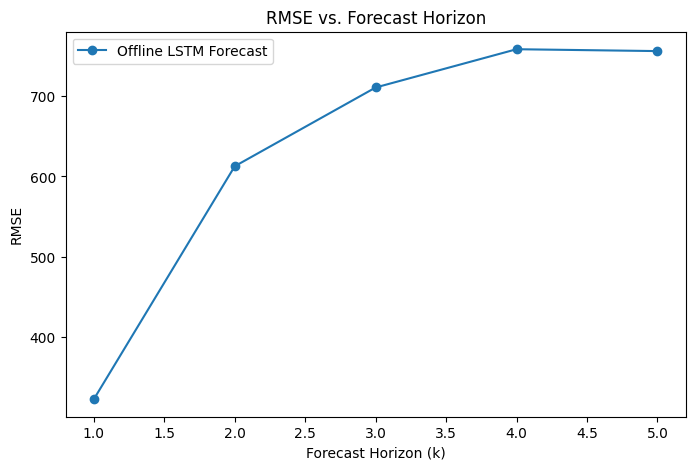

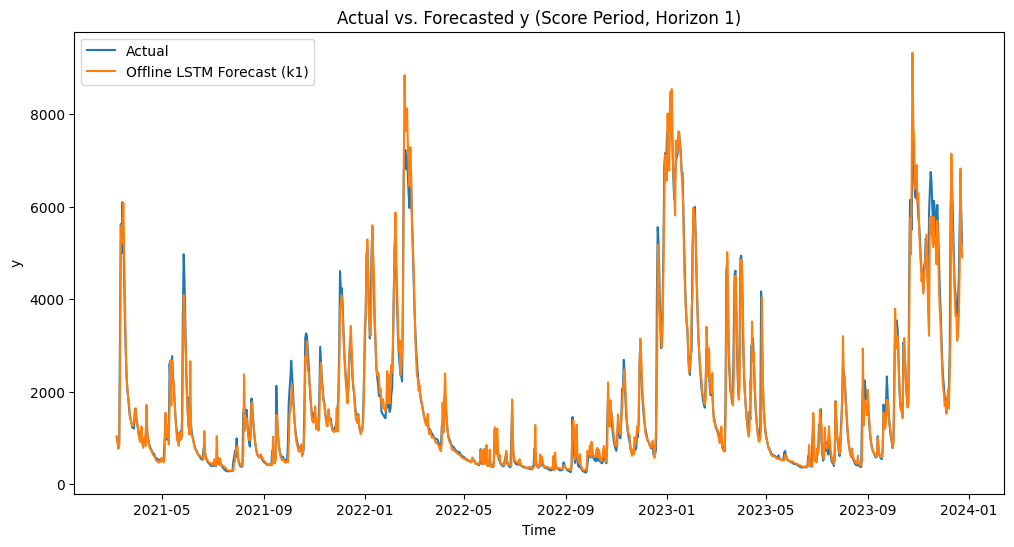

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

######################################
# Data Loading and Preprocessing
######################################

def low_pass(series, a1):
    """Exponential (low-pass) filter."""
    return series.ewm(alpha=1-a1, adjust=False).mean()

# Load the dataset (adjust the path as needed)
data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)

# Convert 'time' to datetime, set index and assign target 'y'
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()

# Data cleaning: Replace abnormal values
temp_mask = D_time_indexed['temp_mean_daily'] > 35
D_time_indexed.loc[temp_mask, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)[temp_mask]
precip_mask = D_time_indexed['precip_total_daily'] > 100
D_time_indexed.loc[precip_mask, 'precip_total_daily'] = 0

# Create forecast features for the target day.
D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = low_pass(D_time_indexed['precip_total_daily'], a1=0.9)
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

# Define the score period: last 1023 days of data used only for evaluation
score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]  # All samples with target dates >= score_start go into the test set

######################################
# Parameters and Dataset Creation Functions
######################################
window_size = 10   # choose between 5 and 15
horizons = [1, 2, 3, 4, 5]  # forecast horizons

def create_offline_dataset_horizon(df, window_size, k, a1=0.9):
    """
    Creates samples for a given forecast horizon k.
    Each sample consists of:
      - Historical input: past window_size days of [y, temp_mean_daily, precip_total_daily]
      - Forecast input: target day's features [temp_forecast, precip_forecast, Year_sin, Year_cos]
            (target day is shifted by (k-1))
      - Label: target day's 'y'
    Also returns an array of target dates.
    """
    X_hist_list = []
    X_forecast_list = []
    y_list = []
    indices = []  # target dates
    for i in range(window_size, len(df) - (k-1)):
        target_date = df.index[i + (k-1)]
        hist = df.iloc[i-window_size:i][['y', 'temp_mean_daily', 'precip_total_daily']].values.astype(np.float32)
        # Forecast features from the target day:
        temp_fc = df.iloc[i + (k-1)]['temp_forecast']
        precip_fc = df.iloc[i + (k-1)]['precip_forecast']
        # Recompute seasonal features from target_date:
        year_sin = np.sin(2 * np.pi * target_date.dayofyear / 365)
        year_cos = np.cos(2 * np.pi * target_date.dayofyear / 365)
        fcst = np.array([temp_fc, precip_fc, year_sin, year_cos], dtype=np.float32)
        label = float(df.iloc[i+(k-1)]['y'])
        
        X_hist_list.append(hist)
        X_forecast_list.append(fcst)
        y_list.append(label)
        indices.append(target_date)
        
    return (np.array(X_hist_list, dtype=np.float32),
            np.array(X_forecast_list, dtype=np.float32),
            np.array(y_list, dtype=np.float32),
            np.array(indices))

######################################
# Model Architecture: Offline LSTM Model
######################################
# Example hyperparameter configuration:
# {'lstm_units': 64, 'dense_units': 64, 'fcst_dense_units': 32, 'combined_units': 64, 'lr': 0.001}
def build_offline_model(window_size):
    """
    Builds the offline LSTM model with two inputs:
      - A sequence input with shape (window_size, 3)
      - A forecast input with shape (4,)
    """
    # Historical branch
    hist_input = Input(shape=(window_size, 3), name='hist_input')
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    
    # Forecast branch
    fcst_input = Input(shape=(4,), name='fcst_input')
    y_branch = Dense(32, activation='relu')(fcst_input)
    y_branch = Dense(32, activation='relu')(y_branch)
    
    # Merge both branches
    combined = Concatenate()([x, y_branch])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

######################################
# Offline Model: Training & Evaluation
######################################

offline_rmse = {}        # RMSE values for each horizon
offline_forecasts = {}   # (dates, actual, predicted) for plotting

for k in horizons:
    print(f"\n--- Offline Model for Horizon {k} ---")
    # Create dataset for this forecast horizon
    X_hist_all, X_fcst_all, y_all, indices_all = create_offline_dataset_horizon(D_time_indexed, window_size, k, a1=0.9)
    # Split samples into training and test sets based on time (target date)
    train_mask = indices_all < score_start
    test_mask = indices_all >= score_start
    
    X_hist_train = X_hist_all[train_mask]
    X_fcst_train = X_fcst_all[train_mask]
    y_train = y_all[train_mask]
    
    X_hist_test = X_hist_all[test_mask]
    X_fcst_test = X_fcst_all[test_mask]
    y_test = y_all[test_mask]
    indices_test = indices_all[test_mask]
    
    print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")
    
    # If no test samples are available for this horizon, skip evaluation.
    if len(y_test) == 0:
        print(f"Horizon {k}: No test samples in score period; skipping evaluation.")
        offline_rmse[f'k{k}'] = np.nan
        offline_forecasts[f'k{k}'] = (np.array([]), np.array([]), np.array([]))
        continue
    
    # Use the last 20% of training data as validation based on time order
    n_train = len(y_train)
    split_index = int(0.8 * n_train)  # first 80% for training, last 20% for validation
    X_hist_train_final = X_hist_train[:split_index]
    X_fcst_train_final = X_fcst_train[:split_index]
    y_train_final = y_train[:split_index]
    
    X_hist_val = X_hist_train[split_index:]
    X_fcst_val = X_fcst_train[split_index:]
    y_val = y_train[split_index:]
    
    # Build the offline model
    offline_model = build_offline_model(window_size)
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'offline_model_h{k}.keras', save_best_only=True)
    ]
    
    # Train the model using the explicit time-based validation set
    history = offline_model.fit(
        [X_hist_train_final, X_fcst_train_final], y_train_final,
        validation_data=([X_hist_val, X_fcst_val], y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Predict on the test set and calculate RMSE
    y_pred = offline_model.predict([X_hist_test, X_fcst_test]).flatten()
    rmse = np.sqrt(np.nanmean((y_pred - y_test) ** 2))
    offline_rmse[f'k{k}'] = rmse
    offline_forecasts[f'k{k}'] = (indices_test, y_test, y_pred)
    print(f"Offline Horizon {k} RMSE: {rmse:.3f}")

######################################
# Plot RMSE vs. Forecast Horizon
######################################
rmse_offline_series = pd.Series(offline_rmse)

plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_offline_series.values, marker='o', label='Offline LSTM Forecast')
plt.xlabel("Forecast Horizon (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Forecast Horizon")
plt.legend()
plt.show()

######################################
# Plot Actual vs. Forecasted (Horizon 1) over the Score Period
######################################
idx_off, y_true_off, y_pred_off = offline_forecasts['k1']

plt.figure(figsize=(12, 6))
plt.plot(idx_off, y_true_off, label='Actual')
plt.plot(idx_off, y_pred_off, label='Offline LSTM Forecast (k1)')
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Actual vs. Forecasted y (Score Period, Horizon 1)")
plt.legend()
plt.show()